# Fairness and Explainability with SageMaker Clarify

1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Initialize SageMaker](#Initialize-SageMaker)
    1. [Download data](#Download-data)
    1. [Loading the data: Adult Dataset](#Loading-the-data:-Adult-Dataset) 
    1. [Data inspection](#Data-inspection) 
    1. [Data encoding and upload to S3](#Encode-and-Upload-Training-Data) 
1. [Train and Deploy XGBoost Model](#Train-XGBoost-Model)
    1. [Train Model](#Train-Model)
    1. [Deploy Model to Endpoint](#Deploy-Model)
1. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)
    1. [Detecting Bias](#Detecting-Bias)
        1. [Writing BiasConfig](#Writing-BiasConfig)
        1. [Pre-training Bias](#Pre-training-Bias)
        1. [Post-training Bias](#Post-training-Bias)
        1. [Viewing the Bias Report](#Viewing-the-Bias-Report)
    1. [Explaining Predictions](#Explaining-Predictions)
        1. [Viewing the Explainability Report](#Viewing-the-Explainability-Report)
1. [Clean Up](#Clean-Up)

## Overview
Amazon SageMaker Clarify helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. The product comes with the tools to help you with the following tasks.

* Measure biases that can occur during each stage of the ML lifecycle (data collection, model training and tuning, and monitoring of ML models deployed for inference).
* Generate model governance reports targeting risk and compliance teams and external regulators.
* Provide explanations of the data, models, and monitoring used to assess predictions.

This sample notebook walks you through:  
1. Key terms and concepts needed to understand SageMaker Clarify
1. Measuring the pre-training bias of a dataset and post-training bias of a model
1. Explaining the importance of the various input features on the model's decision
1. Accessing the reports through SageMaker Studio if you have an instance set up.

## Prerequisites and Data
### Initialize SageMaker

In [1]:
from sagemaker import Session
session = Session()
bucket = session.default_bucket()
prefix = 'sagemaker/DEMO-sagemaker-clarify'
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import urllib
import os

role = get_execution_role()

In [2]:
role

'arn:aws:iam::230755935769:role/SageMakerExecutionRoleMLOps'

### Download data
Data Source: [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)

Let's __download__ the data and save it in the local folder with the name adult.data and adult.test from UCI repository$^{[2]}$.

$^{[2]}$Dua Dheeru, and Efi Karra Taniskidou. "[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml)". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [3]:
adult_columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
                 "Occupation", "Relationship", "Ethnic group", "Sex", "Capital Gain", "Capital Loss",
                 "Hours per week", "Country", "Target"]
if not os.path.isfile('adult.data'):
    urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                              'adult.data')
    print('adult.data saved!')
else:
    print('adult.data already on disk.')

if not os.path.isfile('adult.test'):
    urllib.request.urlretrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                              'adult.test')
    print('adult.test saved!')
else:
    print('adult.test already on disk.')

adult.data already on disk.
adult.test already on disk.


### Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values:
1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next we specify our binary prediction task:  
15. **Target**: <=50,000, >$50,000.

In [4]:
!head -n 10 adult.data 

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K
52, Self-emp-not-inc, 209642, HS-grad, 9, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 45, United-States, >50K
31, 

In [5]:
#one or more space 
training_data = pd.read_csv("adult.data",
                             names=adult_columns,
                             sep=r'\s*,\s*',
                             engine='python',
                             na_values="?").dropna()

testing_data = pd.read_csv("adult.test",
                            names=adult_columns,
                            sep=r'\s*,\s*',
                            engine='python',
                            na_values="?",
                            skiprows=1).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered _sensitive_.  
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

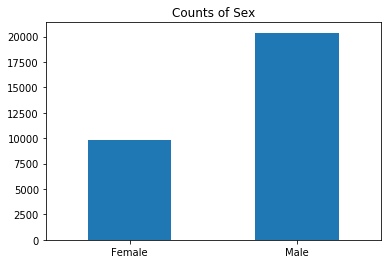

In [6]:
training_data['Sex'].value_counts().sort_values().plot(kind='bar', title='Counts of Sex', rot=0)

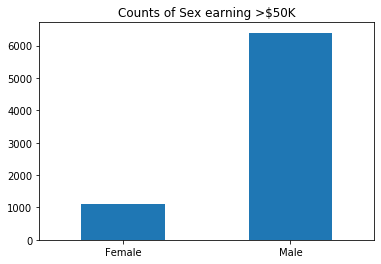

In [7]:
training_data['Sex'].where(training_data['Target']=='>50K').value_counts().sort_values().plot(kind='bar', title='Counts of Sex earning >$50K', rot=0)

### Encode and Upload Training Data
Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for XGBoost models.

In [8]:
from sklearn import preprocessing
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna('None'))
    return result, encoders

training_data = pd.concat([training_data['Target'], training_data.drop(['Target'], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv('train_data.csv', index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(['Target'], axis = 1)
test_target = testing_data['Target']
test_features.to_csv('test_features.csv', index=False, header=False)

In [9]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload('train_data.csv', 's3://{}/{}'.format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type='csv')
test_uri = S3Uploader.upload('test_features.csv', 's3://{}/{}'.format(bucket, prefix))

In [10]:
!head -n 10 train_data.csv

0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4
0,37,2,284582,12,14,2,3,5,4,0,0,0,40,38
0,49,2,160187,6,5,3,7,1,2,0,0,0,16,22
1,52,4,209642,11,9,2,3,0,4,1,0,0,45,38
1,31,2,45781,12,14,4,9,1,4,0,14084,0,50,38
1,42,2,159449,9,13,2,3,0,4,1,5178,0,40,38


A quick note about our encoding: the "Female" Sex value has been encoded as 0 and "Male" as 1.

In [11]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


Lastly, let's upload the model to S3

### Train XGBoost Model
#### Train Model
Since our focus is on understanding how to use SageMaker Clarify, we keep it simple by using a standard XGBoost model.

In [12]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve('xgboost', region, version='1.2-1')
xgb = Estimator(container,
                role,
                instance_count=1,
                instance_type='ml.m4.xlarge',
                disable_profiler=True,
                sagemaker_session=session)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        num_round=800)

xgb.fit({'train': train_input}, logs='None', wait='True')


2021-01-14 15:00:52 Starting - Starting the training job
2021-01-14 15:00:55 Starting - Launching requested ML instances................
2021-01-14 15:02:21 Starting - Preparing the instances for training..............
2021-01-14 15:03:34 Downloading - Downloading input data.
2021-01-14 15:03:47 Training - Downloading the training image.........
2021-01-14 15:04:34 Training - Training image download completed. Training in progress...
2021-01-14 15:04:50 Uploading - Uploading generated training model
2021-01-14 15:04:57 Completed - Training job completed


#### Deploy Model
Here we create the model.

In [13]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

model_name = 'DEMO-clarify-model'
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
# session.create_model(model_name,
#                      role,
#                      container_def)

In [14]:
from datetime import datetime
endpoint_name = f"DEMO-xgb-income-model-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("Endpoint name: ", endpoint_name)
endpoint_instance_count = 1
endpoint_instance_type = "ml.m5.large"
s3_key = f"s3://{bucket}/{prefix}"
s3_capture_upload_path = f'{s3_key}/datacapture'

Endpoint name:  DEMO-xgb-income-model-2021-01-14-1504


In [15]:
from sagemaker.model_monitor import DataCaptureConfig

session.create_model(model_name,
                     role,
                     container_def)

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_upload_path,
)

model.deploy(
    initial_instance_count=endpoint_instance_count,
    instance_type=endpoint_instance_type,
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)


Using already existing model: DEMO-clarify-model


-------------------!

In [16]:
headers = training_data.columns.to_list()

In [17]:
%store model_name
%store container_def
%store train_uri
%store test_uri
%store bucket 
%store prefix 
%store region 
%store headers
%store endpoint_name

Stored 'model_name' (str)
Stored 'container_def' (dict)
Stored 'train_uri' (str)
Stored 'test_uri' (str)
Stored 'bucket' (str)
Stored 'prefix' (str)
Stored 'region' (str)
Stored 'headers' (list)
Stored 'endpoint_name' (str)


## Amazon SageMaker Clarify
Now that you have your model set up. Let's say hello to SageMaker Clarify!

In [18]:
from sagemaker import clarify

bias_report_output_path = 's3://{}/{}/clarify-bias'.format(bucket, prefix)
bias_data_config = clarify.DataConfig(s3_data_input_path=train_uri,
                                      s3_output_path=bias_report_output_path,
                                      label='Target',
                                      headers=training_data.columns.to_list(),
                                      dataset_type='text/csv')

model_config = clarify.ModelConfig(model_name=model_name,
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [19]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=session)

### Detecting Bias
SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.
#### Writing DataConfig and ModelConfig
A `DataConfig` object communicates some basic information about data I/O to Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

Similarly, the `ModelConfig` object communicates information about your trained model and `ModelPredictedLabelConfig` provides information on the format of your predictions.  

**Note**: To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing. `ModelConfig` specifies your preferred instance type and instance count used to run your model on during Clarify's processing.

#### Writing BiasConfig
SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`).
Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

We specify this information in the `BiasConfig` API. Here that the positive outcome is earning >$50,000, Sex is a sensitive category, and Female respondents are the sensitive group.

In [20]:
bias_config = clarify.BiasConfig(label_values_or_threshold=[1],
                                facet_name='Sex',
                                facet_values_or_threshold=[0])

#### Pre-training Bias
Bias can be present in your data before any model training occurs. Inspecting your data for bias before training begins can help detect any data collection gaps, inform your feature engineering, and hep you understand what societal biases the data may reflect.

Computing pre-training bias metrics does not require a trained model.

#### Post-training Bias
Computing post-training bias metrics does require a trained model.

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices.


You can run these options separately with `run_pre_training_bias()` and `run_post_training_bias()` or at the same time with `run_bias()` as shown below.

In [21]:
clarify_processor.run_bias(data_config=bias_data_config,
                           bias_config=bias_config,
                           model_config=model_config,
                           model_predicted_label_config=predictions_config,
                           pre_training_methods='all',
                           post_training_methods='all')


Job Name:  Clarify-Bias-2021-01-14-15-14-35-087
Inputs:  [{'InputName': 'dataset', 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-230755935769/Clarify-Bias-2021-01-14-15-14-35-087/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
................................INFO:sagemaker-clarify-proces

#### Viewing the Bias Report
In Studio, you can view the results under the experiments tab.

<img src="./recordings/bias_report.gif">

Each bias metric has detailed explanations with examples that you can explore.

<img src="./recordings/bias_detail.gif">

You could also summarize the results in a handy table!

<img src="./recordings/bias_report_chart.gif">


If you're not a Studio user yet, you can access the bias report in pdf, html and ipynb formats in the following S3 bucket:

In [22]:
bias_report_output_path

's3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-bias'

### Explaining Predictions
There are expanding business needs and legislative regulations that require explainations of _why_ a model mades the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

In [23]:
shap_config = clarify.SHAPConfig(baseline=[test_features.iloc[0].values.tolist()],
                                 num_samples=15,
                                 agg_method='mean_abs')

explainability_output_path = 's3://{}/{}/clarify-explainability'.format(bucket, prefix)
explainability_data_config = clarify.DataConfig(s3_data_input_path=train_uri,
                                s3_output_path=explainability_output_path,
                                label='Target',
                                headers=training_data.columns.to_list(),
                                dataset_type='text/csv')

In [24]:
clarify_processor.run_explainability(data_config=explainability_data_config,
                                     model_config=model_config,
                                     explainability_config=shap_config)


Job Name:  Clarify-Explainability-2021-01-14-15-27-24-472
Inputs:  [{'InputName': 'dataset', 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-230755935769/Clarify-Explainability-2021-01-14-15-27-24-472/input/analysis_config/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...............................

#### Viewing the Explainability Report
As with the bias report, you can view the explainability report in Studio under the experiments tab


<img src="./recordings/explainability_detail.gif">

The Model Insights tab contains direct links to the report and model insights.

If you're not a Studio user yet, as with the Bias Report, you can access this report at the following S3 bucket.

In [25]:
explainability_output_path

's3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-explainability'

In [26]:
!aws s3 cp --recursive 's3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-explainability' . 

download: s3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/analysis.json to ./analysis.json
download: s3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/report.pdf to ./report.pdf
download: s3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/report.ipynb to ./report.ipynb
download: s3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/report.html to ./report.html
download: s3://sagemaker-us-west-2-230755935769/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/explanations_shap/out.csv to explanations_shap/out.csv


In [27]:
!head -n 10 explanations_shap/out.csv 

Age_label0,Workclass_label0,fnlwgt_label0,Education_label0,Education-Num_label0,Marital Status_label0,Occupation_label0,Relationship_label0,Ethnic group_label0,Sex_label0,Capital Gain_label0,Capital Loss_label0,Hours per week_label0,Country_label0
0.0013564082960459535,0.0009540366641107106,0.00012012891740083179,-0.00047010147908226226,0.0009530321001699977,-0.00045147060380772283,0.0005352729238263182,0.0009901219214174094,8.970458794861435e-05,-0.0004514706038077237,-0.0009803834422979383,-0.00045147060380772326,9.621911502171647e-05,0.000389566708249146
0.015700756354276105,0.008760911893116098,0.008283098941687063,0.0058425213941555336,0.0067179652545783465,0.00976535423288083,0.006486515180226008,0.07932297465845164,0.006402327461186412,0.005861152269430061,0.005861152269430072,0.0058611522694300595,0.0053198897516304414,0.006702189581487161
0.0019906873252882942,0.00013923070141622302,0.00033374883552905765,3.0857765073467704e-06,0.00021486788969063626,0.0011377349866511814,0.00

In [28]:
!pip install shap

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [29]:
features = training_data.drop(['Target'], axis=1)
print(training_data.info())
features.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Target          30162 non-null  int64
 1   Age             30162 non-null  int64
 2   Workclass       30162 non-null  int64
 3   fnlwgt          30162 non-null  int64
 4   Education       30162 non-null  int64
 5   Education-Num   30162 non-null  int64
 6   Marital Status  30162 non-null  int64
 7   Occupation      30162 non-null  int64
 8   Relationship    30162 non-null  int64
 9   Ethnic group    30162 non-null  int64
 10  Sex             30162 non-null  int64
 11  Capital Gain    30162 non-null  int64
 12  Capital Loss    30162 non-null  int64
 13  Hours per week  30162 non-null  int64
 14  Country         30162 non-null  int64
dtypes: int64(15)
memory usage: 3.7 MB
None


Index(['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
       'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age_label0             30162 non-null  float64
 1   Workclass_label0       30162 non-null  float64
 2   fnlwgt_label0          30162 non-null  float64
 3   Education_label0       30162 non-null  float64
 4   Education-Num_label0   30162 non-null  float64
 5   Marital Status_label0  30162 non-null  float64
 6   Occupation_label0      30162 non-null  float64
 7   Relationship_label0    30162 non-null  float64
 8   Ethnic group_label0    30162 non-null  float64
 9   Sex_label0             30162 non-null  float64
 10  Capital Gain_label0    30162 non-null  float64
 11  Capital Loss_label0    30162 non-null  float64
 12  Hours per week_label0  30162 non-null  float64
 13  Country_label0         30162 non-null  float64
dtypes: float64(14)
memory usage: 3.2 MB
None


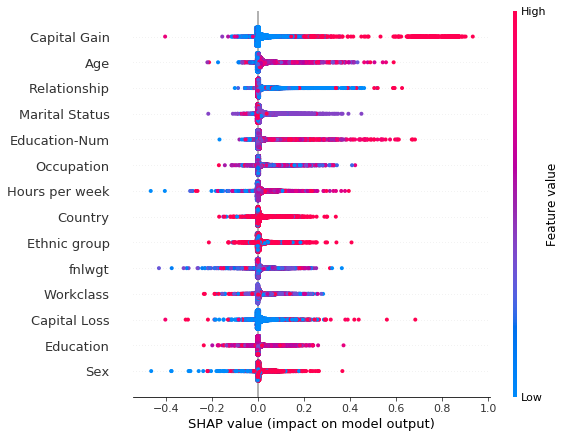

In [30]:
import shap 
exp_data = pd.read_csv('explanations_shap/out.csv')
print(exp_data.info())
shap.summary_plot(shap_values=exp_data.to_numpy(), features=features.values, feature_names=features.columns)

In [31]:


def get_predictions(features): 
    payload = ','.join(features.astype('str').tolist()) 
    print(payload)
    sagemaker_runtime_client = session.sagemaker_runtime_client
    response = sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                Body=payload,
                ContentType='text/csv',
            )
    prediction = float(response["Body"].read().decode("utf-8"))
    return prediction

In [39]:
shap.initjs()
# row=20
row=8
logit_v = get_predictions(training_data.iloc[row,1:])
print(logit_v)

shap.force_plot(0, exp_data.to_numpy()[row], training_data.iloc[row,1:],features.columns, link='logit' )



31,2,45781,12,14,4,9,1,4,0,14084,0,50,38
0.9880510568618774


### Clean Up
Finally, don't forget to clean up the resources we set up and used for this demo!

In [33]:
# session.delete_model(model_name)